**Part 1**

**Checking missing data**

In [1]:
import pandas as pd

# Load dataset
df = pd.read_csv("Leases.csv")

# Filter: large leases and key columns present
df_clean = df[
    (df['leasedSF'] >= 10000) &
    (df['leasedSF'].notna()) &
    (df['internal_class'].notna()) &
    (df['year'].between(2018, 2024))
]

# Drop highly missing columns (>75%)
missing = df_clean.isnull().mean()
df_clean = df_clean.drop(columns=missing[missing > 0.75].index)

# Optional: reset index
df_clean = df_clean.reset_index(drop=True)

# Save for use
df_clean.to_csv("Filtered_Leases.csv", index=False)


**Filtering data to ensure meaningful variables, and data quality**

In [2]:
# Filter: large leases and key columns present
df_clean = df[
    (df['leasedSF'] >= 10000) &
    (df['leasedSF'].notna()) &
    (df['internal_class'].notna()) &
    (df['year'].between(2018, 2024))
]

# Drop highly missing columns (>75%)
missing = df_clean.isnull().mean()
df_clean = df_clean.drop(columns=missing[missing > 0.75].index)

# Optional: reset index
df_clean = df_clean.reset_index(drop=True)

# Save for use
df_clean.to_csv("Filtered_Leases.csv", index=False)

**Part 1**

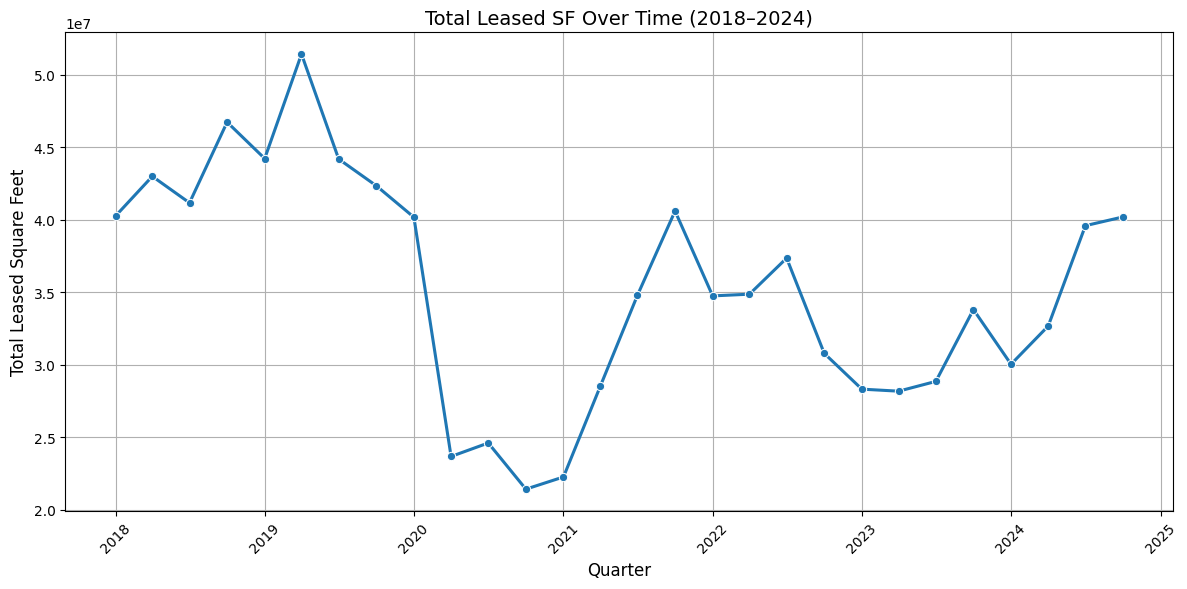

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Load the filtered dataset
df = pd.read_csv("Filtered_Leases.csv")

# Group by year + quarter and sum leasedSF
quarterly_total = df.groupby(['year', 'quarter'])['leasedSF'].sum().reset_index()

#clean 'Q1', 'Q2' strings to extract numeric quarter
quarterly_total['quarter'] = quarterly_total['quarter'].astype(str).str.extract('(\d)').astype(int)
quarterly_total['year'] = quarterly_total['year'].astype(int)

# build PeriodIndex from year and quarter
quarterly_total['time'] = pd.PeriodIndex.from_fields(
    year=quarterly_total['year'],
    quarter=quarterly_total['quarter'],
    freq='Q'
).to_timestamp()

# Plot the time series
plt.figure(figsize=(12,6))
sns.lineplot(data=quarterly_total, x='time', y='leasedSF', marker='o', linewidth=2.2)
plt.title("Total Leased SF Over Time (2018–2024)", fontsize=14)
plt.ylabel("Total Leased Square Feet", fontsize=12)
plt.xlabel("Quarter", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

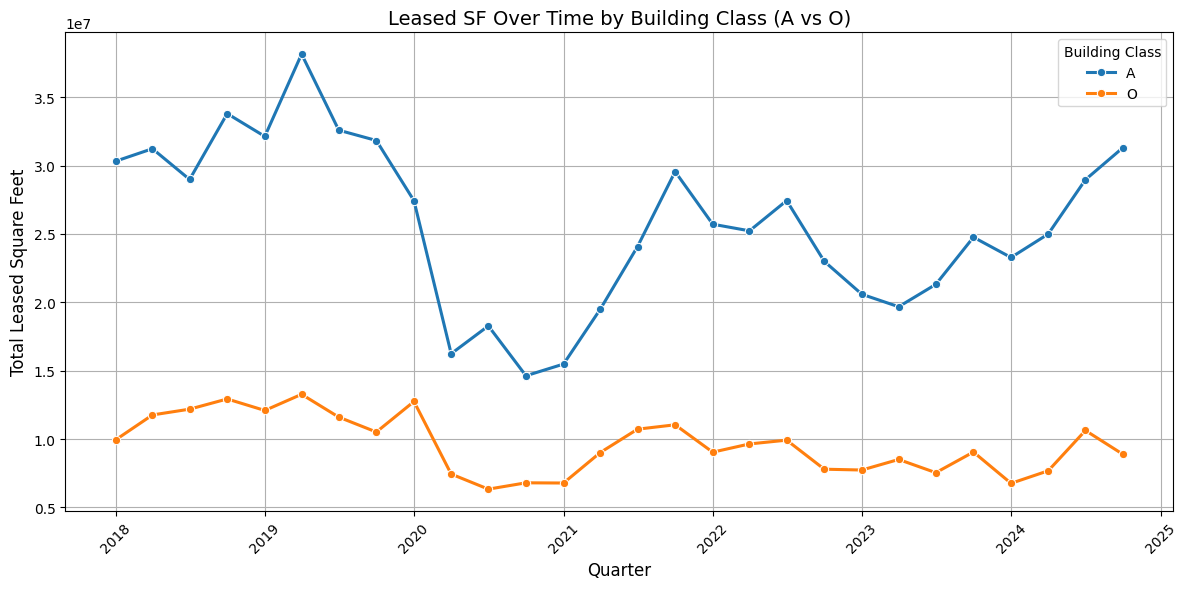

In [11]:
# Load filtered dataset
df = pd.read_csv("Filtered_Leases.csv")

# Extract numeric quarter if needed
df['quarter'] = df['quarter'].astype(str).str.extract('(\d)').astype(int)
df['year'] = df['year'].astype(int)

# Group by year, quarter, and internal_class
class_qtr = df.groupby(['year', 'quarter', 'internal_class'])['leasedSF'].sum().reset_index()

# Build datetime column
class_qtr['time'] = pd.PeriodIndex.from_fields(
    year=class_qtr['year'],
    quarter=class_qtr['quarter'],
    freq='Q'
).to_timestamp()

# Plot by internal_class (A vs O)
plt.figure(figsize=(12,6))
sns.lineplot(data=class_qtr, x='time', y='leasedSF', hue='internal_class', marker='o', linewidth=2.2)
plt.title("Leased SF Over Time by Building Class (A vs O)", fontsize=14)
plt.ylabel("Total Leased Square Feet", fontsize=12)
plt.xlabel("Quarter", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Building Class')
plt.tight_layout()
plt.show()

In [4]:
from scipy.stats import kruskal

# Assign period labels
def assign_period(year):
    if year in [2018, 2019]:
        return 'Pre-COVID'
    elif year in [2020, 2021]:
        return 'During COVID'
    else:
        return 'Post-COVID'

df['period'] = df['year'].apply(assign_period)

# Filter leasedSF by period
pre = df[df['period'] == 'Pre-COVID']['leasedSF']
during = df[df['period'] == 'During COVID']['leasedSF']
post = df[df['period'] == 'Post-COVID']['leasedSF']

# Run Kruskal-Wallis test
stat, p = kruskal(pre, during, post)
print(f"Kruskal-Wallis H = {stat:.3f}, p-value = {p:.14f}")

if p < 0.05:
    print("✅ Significant difference in leased space across periods.")
else:
    print("❌ No significant difference in leased space across periods.")


Kruskal-Wallis H = 55.750, p-value = 0.00000000000078
✅ Significant difference in leased space across periods.


In [5]:
from scipy.stats import kruskal

# Filter datasets by class
df_A = df[df['internal_class'] == 'A']
df_O = df[df['internal_class'] == 'O']

# Assign COVID period to each subset (if not already done)
df_A['period'] = df_A['year'].apply(assign_period)
df_O['period'] = df_O['year'].apply(assign_period)

# Class A leasing per period
pre_A = df_A[df_A['period'] == 'Pre-COVID']['leasedSF']
during_A = df_A[df_A['period'] == 'During COVID']['leasedSF']
post_A = df_A[df_A['period'] == 'Post-COVID']['leasedSF']

# Class O leasing per period
pre_O = df_O[df_O['period'] == 'Pre-COVID']['leasedSF']
during_O = df_O[df_O['period'] == 'During COVID']['leasedSF']
post_O = df_O[df_O['period'] == 'Post-COVID']['leasedSF']

# Run Kruskal-Wallis tests
stat_A, p_A = kruskal(pre_A, during_A, post_A)
stat_O, p_O = kruskal(pre_O, during_O, post_O)

# Print results
print(f"\nClass A - Kruskal-Wallis H = {stat_A:.3f}, p = {p_A:.5f}")
if p_A < 0.05:
    print("✅ Significant leasing change for Class A across COVID periods.")
else:
    print("❌ No significant leasing change for Class A.")

print(f"\nClass O - Kruskal-Wallis H = {stat_O:.3f}, p = {p_O:.5f}")
if p_O < 0.05:
    print("✅ Significant leasing change for Class O across COVID periods.")
else:
    print("❌ No significant leasing change for Class O.")



Class A - Kruskal-Wallis H = 36.336, p = 0.00000
✅ Significant leasing change for Class A across COVID periods.

Class O - Kruskal-Wallis H = 37.780, p = 0.00000
✅ Significant leasing change for Class O across COVID periods.


C:\Users\Kinshuk Mangal\AppData\Local\Temp\ipykernel_23804\2901148736.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_A['period'] = df_A['year'].apply(assign_period)
C:\Users\Kinshuk Mangal\AppData\Local\Temp\ipykernel_23804\2901148736.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_O['period'] = df_O['year'].apply(assign_period)


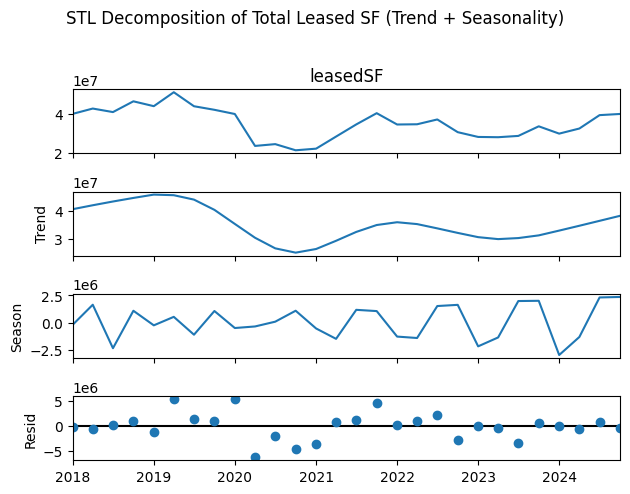

In [6]:
from statsmodels.tsa.seasonal import STL

# Load and prepare time series
df = pd.read_csv("Filtered_Leases.csv")

# Ensure quarter is numeric
df['quarter'] = df['quarter'].astype(str).str.extract('(\d)').astype(int)
df['year'] = df['year'].astype(int)

# Group by time (quarterly total)
qtr_total = df.groupby(['year', 'quarter'])['leasedSF'].sum().reset_index()

# Create datetime index
qtr_total['time'] = pd.PeriodIndex.from_fields(
    year=qtr_total['year'],
    quarter=qtr_total['quarter'],
    freq='Q'
).to_timestamp()

# Set time as index
ts = qtr_total.set_index('time')['leasedSF']

# Run STL decomposition (seasonal period = 4 for quarters)
stl = STL(ts, period=4)
res = stl.fit()

# Plot STL decomposition
res.plot()
plt.suptitle("STL Decomposition of Total Leased SF (Trend + Seasonality)", y=1.02)
plt.tight_layout()
plt.show()

**Part 2**

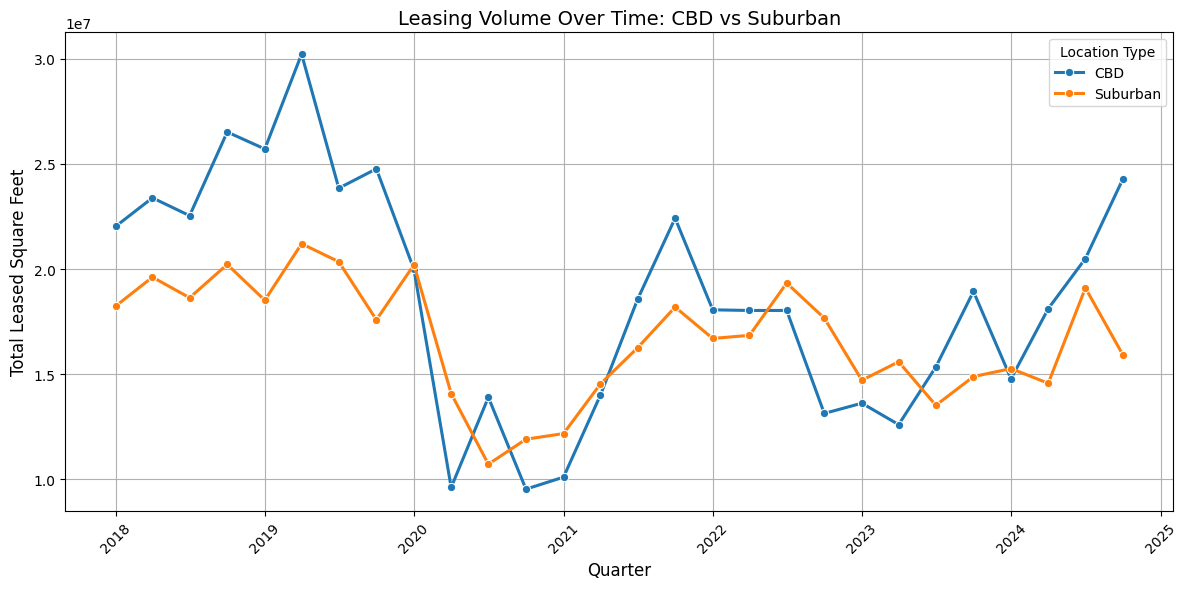

In [7]:
# Load filtered dataset
df = pd.read_csv("Filtered_Leases.csv")

# Clean quarter and year
df['quarter'] = df['quarter'].astype(str).str.extract('(\d)').astype(int)
df['year'] = df['year'].astype(int)

# Group by year, quarter, and CBD_suburban
cbd_trend = df.groupby(['year', 'quarter', 'CBD_suburban'])['leasedSF'].sum().reset_index()

# Create time column
cbd_trend['time'] = pd.PeriodIndex.from_fields(
    year=cbd_trend['year'],
    quarter=cbd_trend['quarter'],
    freq='Q'
).to_timestamp()

# Plot leasing volume over time by CBD vs Suburban
plt.figure(figsize=(12,6))
sns.lineplot(data=cbd_trend, x='time', y='leasedSF', hue='CBD_suburban', marker='o', linewidth=2.2)
plt.title("Leasing Volume Over Time: CBD vs Suburban", fontsize=14)
plt.ylabel("Total Leased Square Feet", fontsize=12)
plt.xlabel("Quarter", fontsize=12)
plt.grid(True)
plt.legend(title='Location Type')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:
from scipy.stats import kruskal

# Assign COVID period labels
def assign_period(year):
    if year in [2018, 2019]:
        return 'Pre-COVID'
    elif year in [2020, 2021]:
        return 'During COVID'
    else:
        return 'Post-COVID'

df['period'] = df['year'].apply(assign_period)

# Split by CBD vs Suburban
df_cbd = df[df['CBD_suburban'] == 'CBD']
df_sub = df[df['CBD_suburban'] == 'Suburban']

# Extract leasedSF for each period
pre_cbd = df_cbd[df_cbd['period'] == 'Pre-COVID']['leasedSF']
during_cbd = df_cbd[df_cbd['period'] == 'During COVID']['leasedSF']
post_cbd = df_cbd[df_cbd['period'] == 'Post-COVID']['leasedSF']

pre_sub = df_sub[df_sub['period'] == 'Pre-COVID']['leasedSF']
during_sub = df_sub[df_sub['period'] == 'During COVID']['leasedSF']
post_sub = df_sub[df_sub['period'] == 'Post-COVID']['leasedSF']

# Run Kruskal-Wallis tests
stat_cbd, p_cbd = kruskal(pre_cbd, during_cbd, post_cbd)
stat_sub, p_sub = kruskal(pre_sub, during_sub, post_sub)

# Print results
print(f"\nCBD - Kruskal-Wallis H = {stat_cbd:.3f}, p = {p_cbd:.5f}")
if p_cbd < 0.05:
    print("✅ Significant leasing change for CBD across periods.")
else:
    print("❌ No significant leasing change for CBD.")

print(f"\nSuburban - Kruskal-Wallis H = {stat_sub:.3f}, p = {p_sub:.5f}")
if p_sub < 0.05:
    print("✅ Significant leasing change for Suburban across periods.")
else:
    print("❌ No significant leasing change for Suburban.")



CBD - Kruskal-Wallis H = 40.672, p = 0.00000
✅ Significant leasing change for CBD across periods.

Suburban - Kruskal-Wallis H = 18.086, p = 0.00012
✅ Significant leasing change for Suburban across periods.


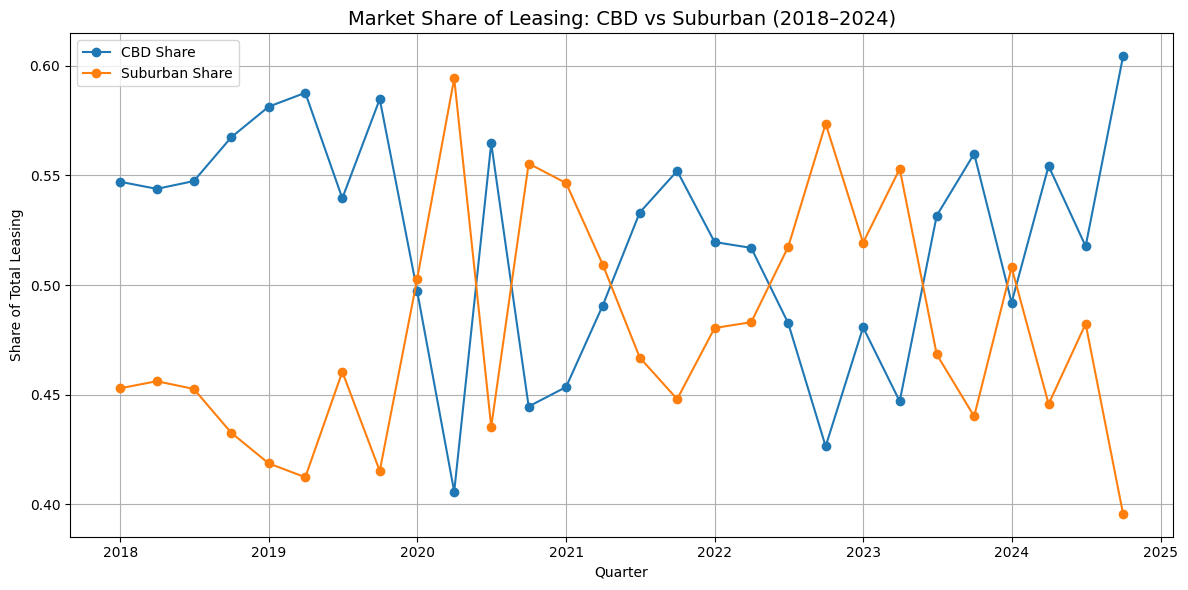

In [9]:
# Group and sum leasedSF by time and CBD_suburban
df['quarter'] = df['quarter'].astype(str).str.extract('(\d)').astype(int)
df['year'] = df['year'].astype(int)

cbd_share = df.groupby(['year', 'quarter', 'CBD_suburban'])['leasedSF'].sum().reset_index()

# Create proper datetime for plotting
cbd_share['time'] = pd.PeriodIndex.from_fields(
    year=cbd_share['year'],
    quarter=cbd_share['quarter'],
    freq='Q'
).to_timestamp()

# Pivot to get separate columns for CBD and Suburban
pivot_df = cbd_share.pivot(index='time', columns='CBD_suburban', values='leasedSF')

# Calculate % share of each
pivot_df['Total'] = pivot_df.sum(axis=1)
pivot_df['CBD_share'] = pivot_df['CBD'] / pivot_df['Total']
pivot_df['Suburban_share'] = pivot_df['Suburban'] / pivot_df['Total']

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(pivot_df.index, pivot_df['CBD_share'], label='CBD Share', marker='o')
plt.plot(pivot_df.index, pivot_df['Suburban_share'], label='Suburban Share', marker='o')
plt.title('Market Share of Leasing: CBD vs Suburban (2018–2024)', fontsize=14)
plt.ylabel('Share of Total Leasing')
plt.xlabel('Quarter')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Part 3**

In [10]:
# Check unique values and missingness in industry/sector
print("Missing %:", df['internal_industry'].isna().mean() * 100)
print("Top industry labels (non-null):")
print(df['internal_industry'].dropna().value_counts().head(10))


Missing %: 42.39524576954069
Top industry labels (non-null):
internal_industry
Technology, Advertising, Media, and Information                                                        3018
Financial Services and Insurance                                                                       2822
Business, Professional, and Consulting Services (except Financial and Legal) - Including Accounting    1768
Legal Services                                                                                         1469
TBD                                                                                                    1172
Construction, Engineering and Architecture                                                              867
Healthcare                                                                                              833
Retail                                                                                                  679
Government                                               

C:\Users\Kinshuk Mangal\AppData\Local\Temp\ipykernel_23804\3638795444.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=industry_avg, x='leasedSF', y='internal_industry', palette='viridis')


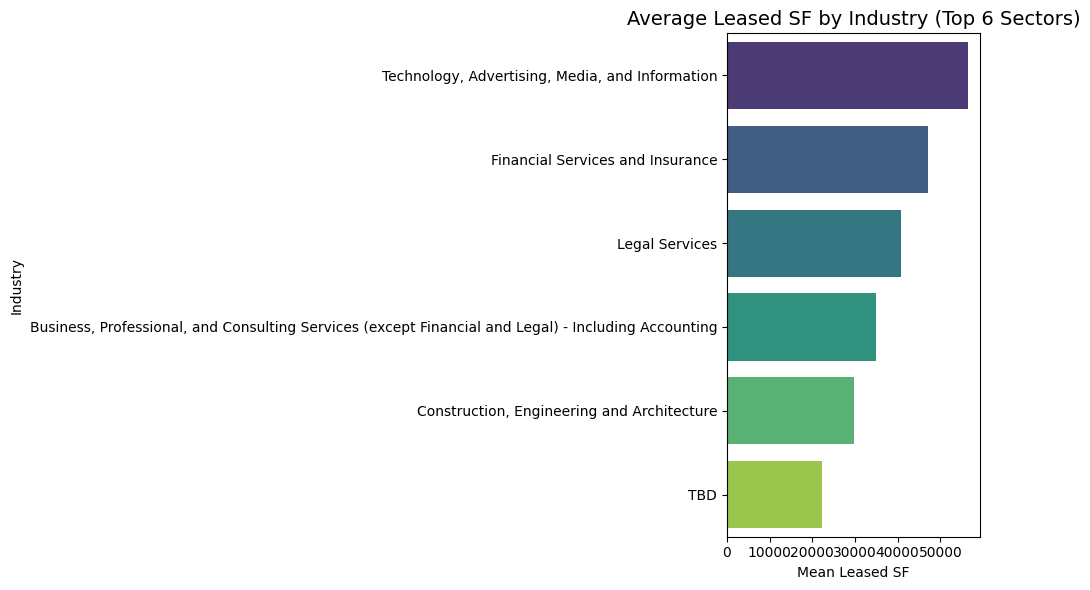

In [11]:
# Load your filtered dataset (or use df if already in memory)
# df = pd.read_csv("Filtered_Leases.csv")  # uncomment if needed

# Filter to rows with non-null industries
df_industry = df[df['internal_industry'].notna()]

# Get top 6 most common industries
top_industries = df_industry['internal_industry'].value_counts().head(6).index

# Filter only to those industries
df_top = df_industry[df_industry['internal_industry'].isin(top_industries)]

# Calculate average leasedSF per industry
industry_avg = df_top.groupby('internal_industry')['leasedSF'].mean().sort_values(ascending=False).reset_index()

# Plot the average leased square footage
plt.figure(figsize=(10,6))
sns.barplot(data=industry_avg, x='leasedSF', y='internal_industry', palette='viridis')
plt.title("Average Leased SF by Industry (Top 6 Sectors)", fontsize=14)
plt.xlabel("Mean Leased SF")
plt.ylabel("Industry")
plt.tight_layout()
plt.show()


In [12]:
from scipy.stats import f_oneway

# Filter to top 6 industries (same as before)
df_industry = df[df['internal_industry'].notna()]
top_industries = df_industry['internal_industry'].value_counts().head(6).index
df_top = df_industry[df_industry['internal_industry'].isin(top_industries)]

# Group leasedSF into lists by industry
groups = [group['leasedSF'].values for name, group in df_top.groupby('internal_industry')]

# Run one-way ANOVA
f_stat, p_value = f_oneway(*groups)

# Output
print(f"ANOVA F-statistic = {f_stat:.3f}, p-value = {p_value:.5f}")

if p_value < 0.05:
    print("✅ Significant difference in mean leased SF across industries.")
else:
    print("❌ No significant difference in mean leased SF across industries.")


ANOVA F-statistic = 60.570, p-value = 0.00000
✅ Significant difference in mean leased SF across industries.


In [13]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import statsmodels.api as sm

# Use only top 6 industries with non-null leasedSF
df_industry = df[df['internal_industry'].notna()]
top_industries = df_industry['internal_industry'].value_counts().head(6).index
df_top = df_industry[df_industry['internal_industry'].isin(top_industries)]

# Run Tukey's HSD
tukey = pairwise_tukeyhsd(
    endog=df_top['leasedSF'],                  # dependent variable
    groups=df_top['internal_industry'],        # group labels
    alpha=0.05
)

# Display the summary table
print(tukey.summary())


                                                                         Multiple Comparison of Means - Tukey HSD, FWER=0.05                                                                         
                                               group1                                                                    group2                       meandiff  p-adj     lower       upper    reject
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Business, Professional, and Consulting Services (except Financial and Legal) - Including Accounting      Construction, Engineering and Architecture  -5116.3943 0.4456  -13080.462   2847.6735  False
Business, Professional, and Consulting Services (except Financial and Legal) - Including Accounting                Financial Services and Insurance  12311.8876    0.0   6485.7327  18138.0424   True
Business, 

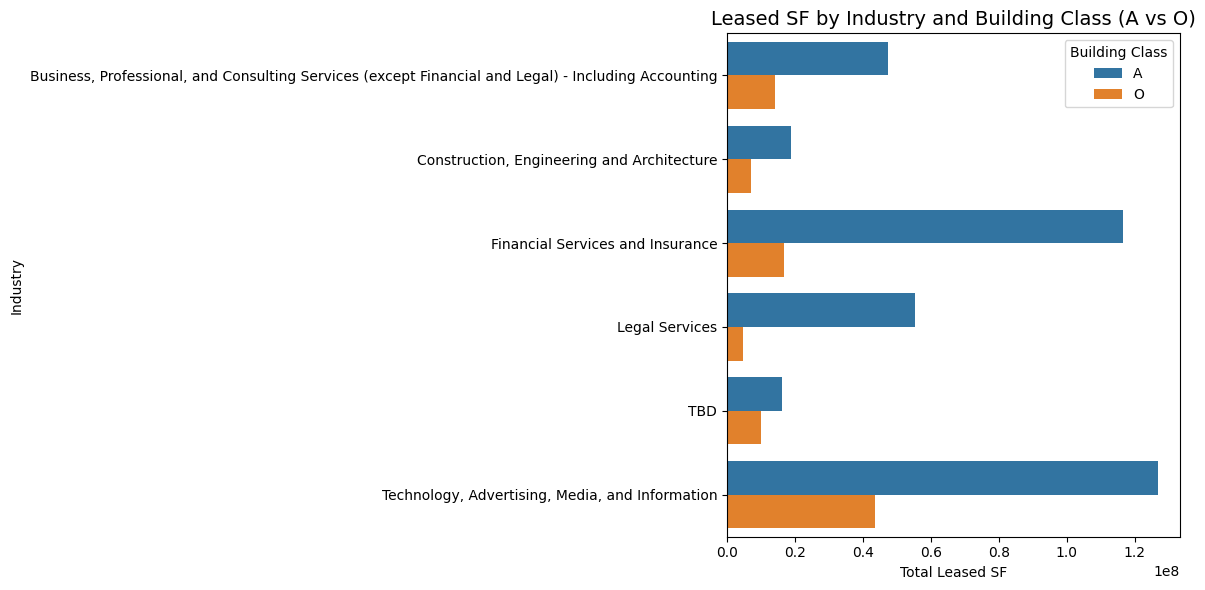

In [14]:
# Filter to top 6 industries again
df_top = df[df['internal_industry'].notna()]
top_industries = df_top['internal_industry'].value_counts().head(6).index
df_top = df_top[df_top['internal_industry'].isin(top_industries)]

# Group by industry and class
industry_class = df_top.groupby(['internal_industry', 'internal_class'])['leasedSF'].sum().reset_index()

# Plot
plt.figure(figsize=(12,6))
sns.barplot(data=industry_class, x='leasedSF', y='internal_industry', hue='internal_class')
plt.title("Leased SF by Industry and Building Class (A vs O)", fontsize=14)
plt.xlabel("Total Leased SF")
plt.ylabel("Industry")
plt.legend(title="Building Class")
plt.tight_layout()
plt.show()


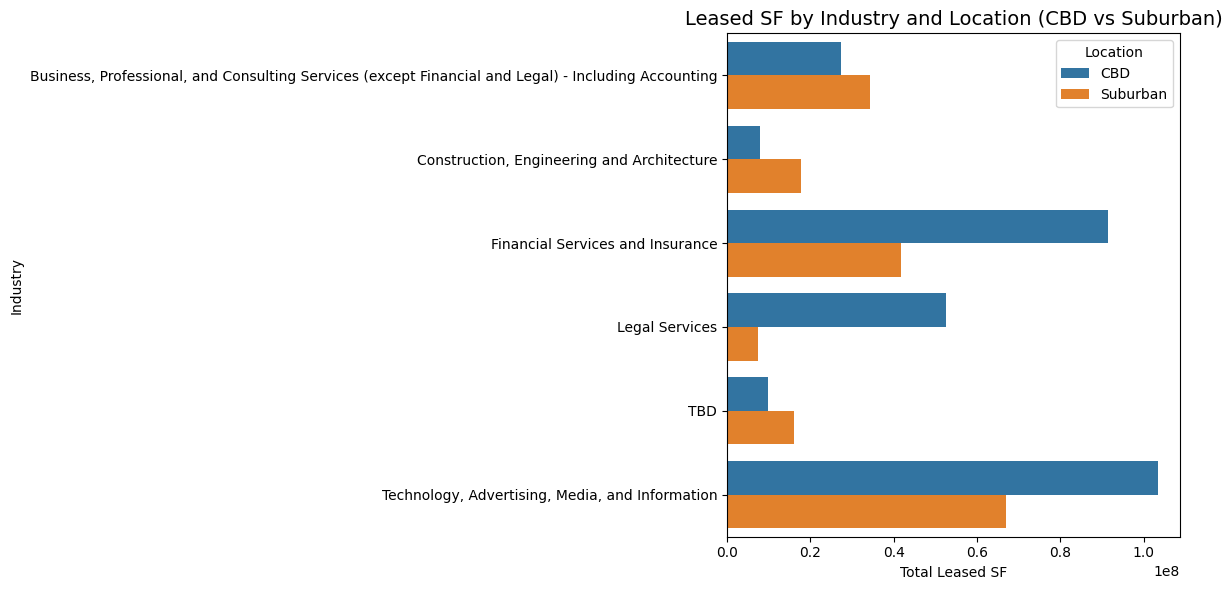

In [32]:
# Group by industry and CBD_suburban
industry_location = df_top.groupby(['internal_industry', 'CBD_suburban'])['leasedSF'].sum().reset_index()

# Plot
plt.figure(figsize=(12,6))
sns.barplot(data=industry_location, x='leasedSF', y='internal_industry', hue='CBD_suburban')
plt.title("Leased SF by Industry and Location (CBD vs Suburban)", fontsize=14)
plt.xlabel("Total Leased SF")
plt.ylabel("Industry")
plt.legend(title="Location")
plt.tight_layout()
plt.show()


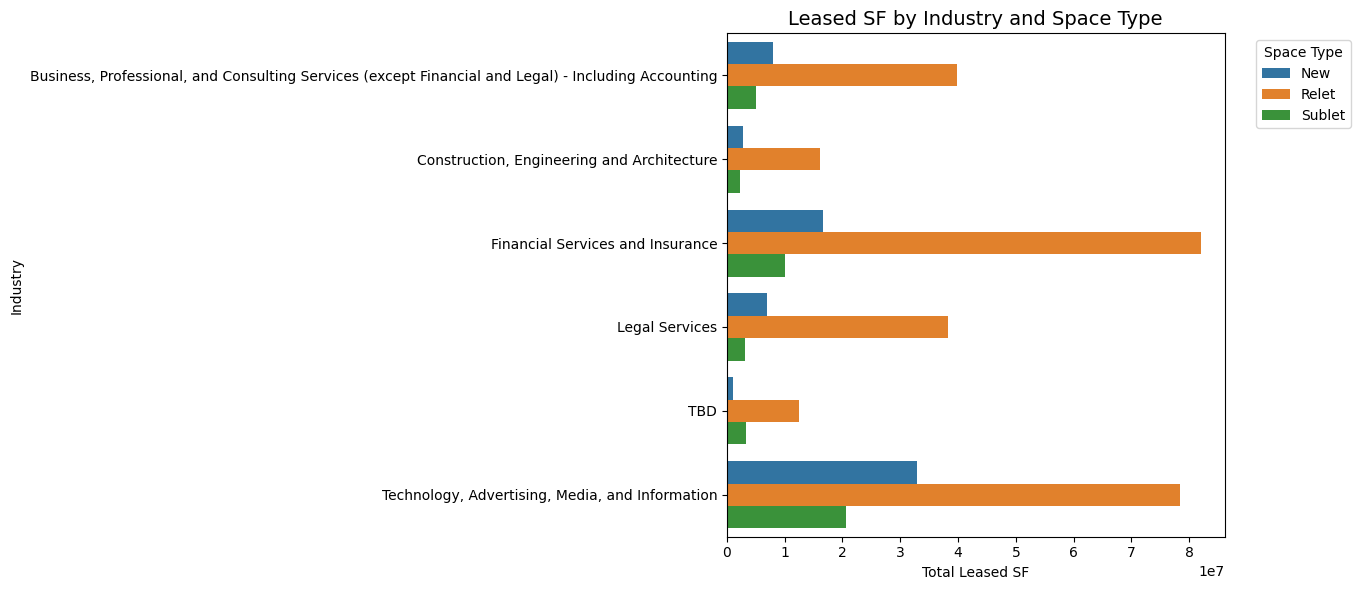

In [15]:
# Drop null space types just in case
df_space = df_top[df_top['space_type'].notna()]

# Group by industry and space_type
industry_space = df_space.groupby(['internal_industry', 'space_type'])['leasedSF'].sum().reset_index()

# Plot
plt.figure(figsize=(14,6))
sns.barplot(data=industry_space, x='leasedSF', y='internal_industry', hue='space_type')
plt.title("Leased SF by Industry and Space Type", fontsize=14)
plt.xlabel("Total Leased SF")
plt.ylabel("Industry")
plt.legend(title="Space Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

**Part 4**

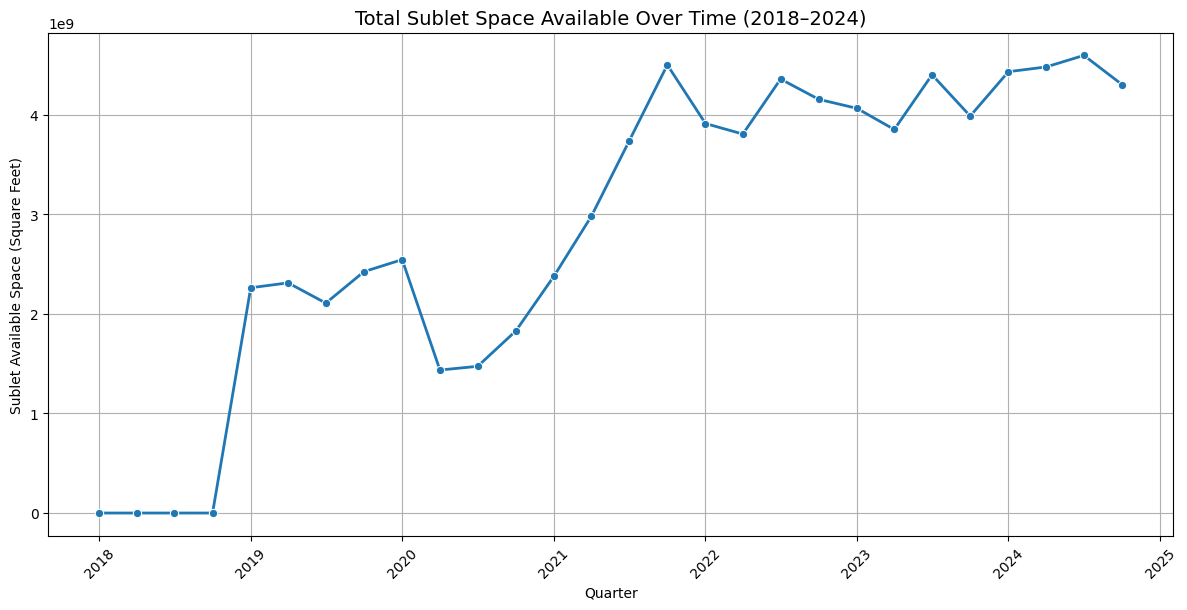

In [16]:
# Load dataset (skip if already loaded)
# df = pd.read_csv("Filtered_Leases.csv")

# Ensure quarter is numeric
df['quarter'] = df['quarter'].astype(str).str.extract('(\d)').astype(int)
df['year'] = df['year'].astype(int)

# Group by year and quarter, summing sublease space
sublet_qtr = df.groupby(['year', 'quarter'])['sublet_available_space'].sum().reset_index()

# Create proper datetime column
sublet_qtr['time'] = pd.PeriodIndex.from_fields(
    year=sublet_qtr['year'],
    quarter=sublet_qtr['quarter'],
    freq='Q'
).to_timestamp()

# Plot sublease availability over time
plt.figure(figsize=(12,6))
sns.lineplot(data=sublet_qtr, x='time', y='sublet_available_space', marker='o', linewidth=2)
plt.title("Total Sublet Space Available Over Time (2018–2024)", fontsize=14)
plt.xlabel("Quarter")
plt.ylabel("Sublet Available Space (Square Feet)")
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()


In [37]:
from scipy.stats import kruskal

# Create COVID period column
def assign_period(year):
    if year in [2018, 2019]:
        return 'Pre-COVID'
    elif year in [2020, 2021]:
        return 'During COVID'
    else:
        return 'Post-COVID'

df['period'] = df['year'].apply(assign_period)

# Group sublet space by COVID period
pre = df[df['period'] == 'Pre-COVID']['sublet_available_space'].dropna()
during = df[df['period'] == 'During COVID']['sublet_available_space'].dropna()
post = df[df['period'] == 'Post-COVID']['sublet_available_space'].dropna()

# Run Kruskal-Wallis test
stat, p_value = kruskal(pre, during, post)

# Output results
print(f"Kruskal-Wallis H = {stat:.3f}, p = {p_value:.5f}")
if p_value < 0.05:
    print("✅ Significant difference in sublet availability across periods.")
else:
    print("❌ No significant difference in sublet availability across periods.")


Kruskal-Wallis H = 1820.841, p = 0.00000
✅ Significant difference in sublet availability across periods.


C:\Users\Kinshuk Mangal\AppData\Local\Temp\ipykernel_35080\3781409515.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=industry_sublet, x='sublet_available_space', y='internal_industry', palette='crest')


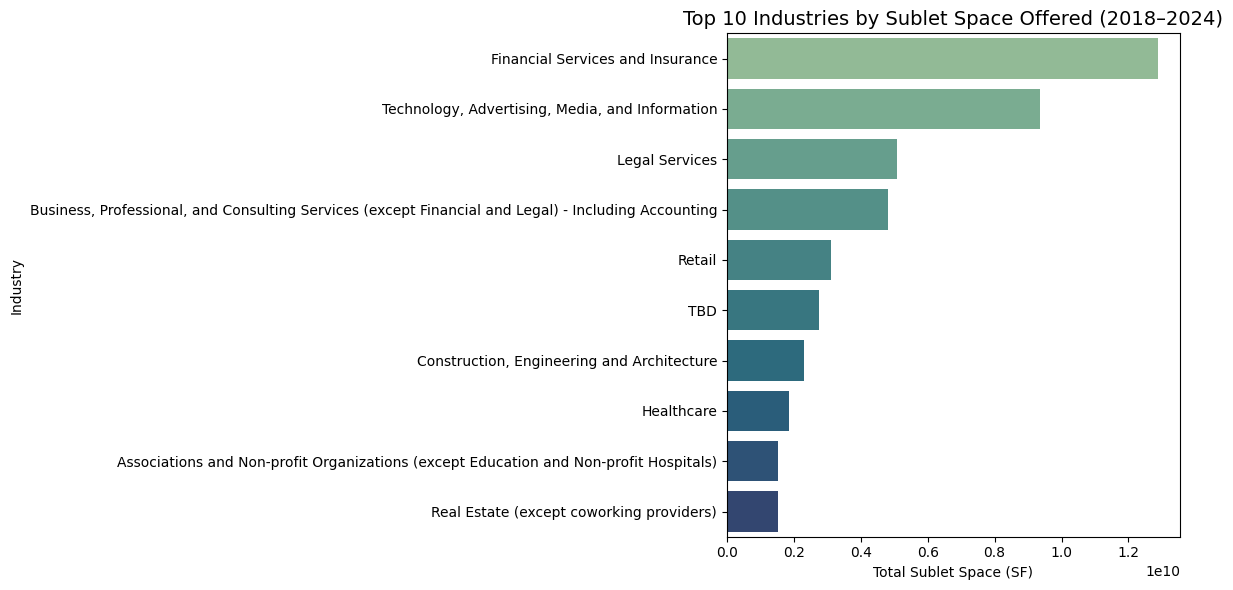

In [38]:
# Filter out missing industries
df_industry = df[df['internal_industry'].notna()]

# Group by industry and sum sublet space
industry_sublet = df_industry.groupby('internal_industry')['sublet_available_space'].sum().sort_values(ascending=False).head(10).reset_index()

# Plot
plt.figure(figsize=(12,6))
sns.barplot(data=industry_sublet, x='sublet_available_space', y='internal_industry', palette='crest')
plt.title("Top 10 Industries by Sublet Space Offered (2018–2024)", fontsize=14)
plt.xlabel("Total Sublet Space (SF)")
plt.ylabel("Industry")
plt.tight_layout()
plt.show()


C:\Users\Kinshuk Mangal\AppData\Local\Temp\ipykernel_23804\2789529796.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=region_sublet, x='sublet_available_space', y='region', palette='flare')


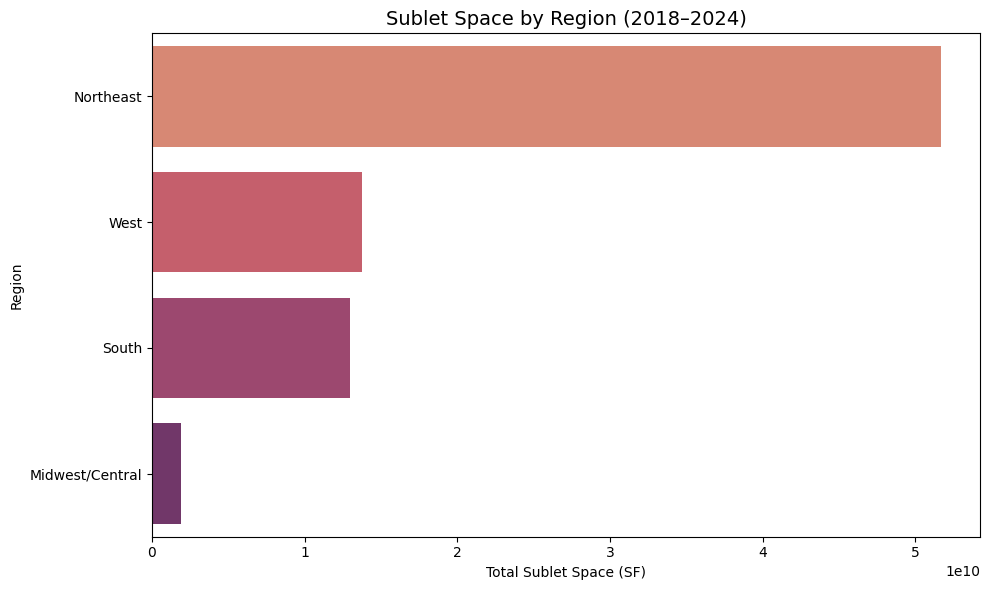

In [19]:
region_sublet = df.groupby('region')['sublet_available_space'].sum().sort_values(ascending=False).reset_index()

plt.figure(figsize=(10,6))
sns.barplot(data=region_sublet, x='sublet_available_space', y='region', palette='flare')
plt.title("Sublet Space by Region (2018–2024)", fontsize=14)
plt.xlabel("Total Sublet Space (SF)")
plt.ylabel("Region")
plt.tight_layout()
plt.show()


C:\Users\Kinshuk Mangal\AppData\Local\Temp\ipykernel_23804\44452178.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=class_sublet, x='internal_class', y='sublet_available_space', palette='mako')


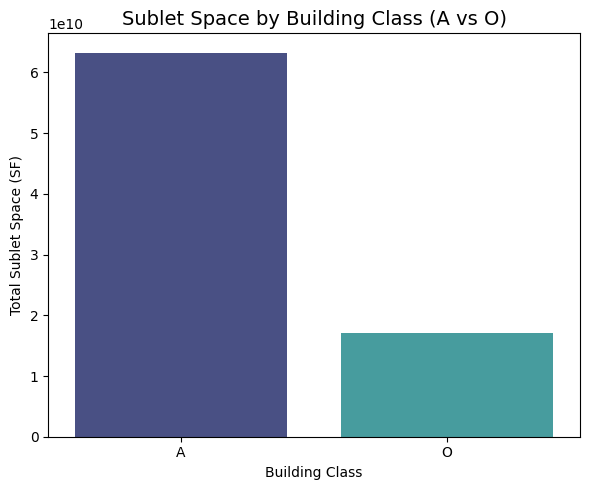

In [18]:
class_sublet = df.groupby('internal_class')['sublet_available_space'].sum().sort_values(ascending=False).reset_index()

plt.figure(figsize=(6,5))
sns.barplot(data=class_sublet, x='internal_class', y='sublet_available_space', palette='mako')
plt.title("Sublet Space by Building Class (A vs O)", fontsize=14)
plt.xlabel("Building Class")
plt.ylabel("Total Sublet Space (SF)")
plt.tight_layout()
plt.show()


**Part 5**

C:\Users\Kinshuk Mangal\AppData\Local\Temp\ipykernel_23804\116790839.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_cities, x='leasedSF', y='city', palette='viridis')


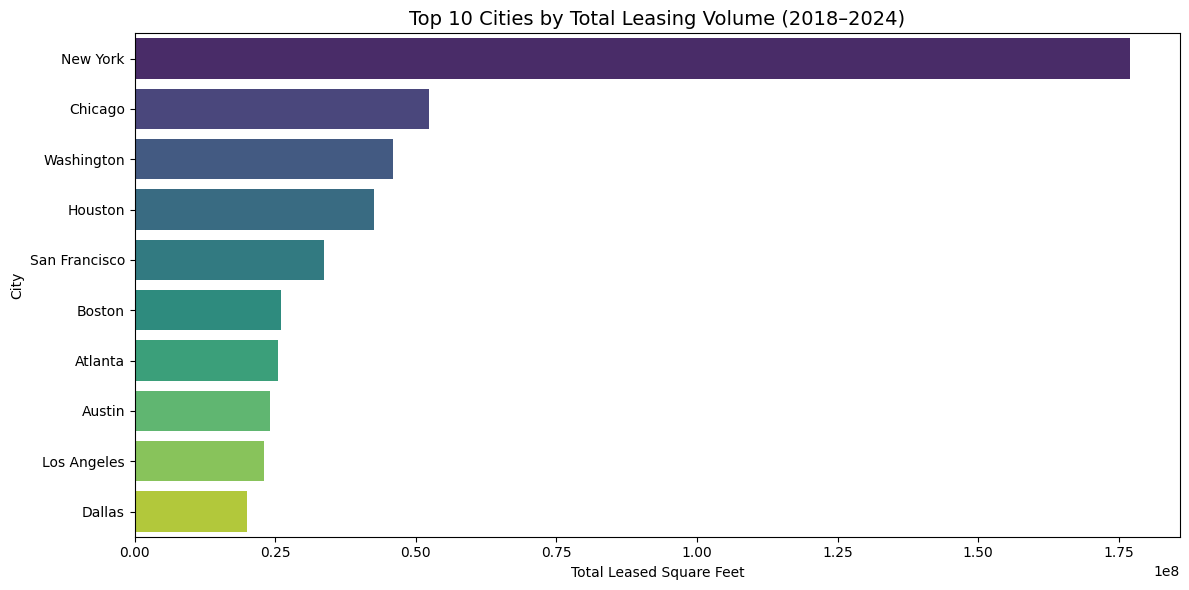

In [20]:
# Group by city and sum total leasedSF
top_cities = df.groupby('city')['leasedSF'].sum().sort_values(ascending=False).head(10).reset_index()

# Plot
plt.figure(figsize=(12,6))
sns.barplot(data=top_cities, x='leasedSF', y='city', palette='viridis')
plt.title("Top 10 Cities by Total Leasing Volume (2018–2024)", fontsize=14)
plt.xlabel("Total Leased Square Feet")
plt.ylabel("City")
plt.tight_layout()
plt.show()


In [21]:
# Assign COVID periods
def assign_period(year):
    if year in [2018, 2019]:
        return 'Pre-COVID'
    elif year in [2020, 2021]:
        return 'During COVID'
    else:
        return 'Post-COVID'

df['period'] = df['year'].apply(assign_period)

# Group by period and city, sum leasedSF
city_period = df.groupby(['period', 'city'])['leasedSF'].sum().reset_index()

# For each period, get top 10 cities
top_pre = city_period[city_period['period'] == 'Pre-COVID'].sort_values('leasedSF', ascending=False).head(10)
top_post = city_period[city_period['period'] == 'Post-COVID'].sort_values('leasedSF', ascending=False).head(10)

# Show side-by-side comparison
print("Top Cities - Pre-COVID:\n", top_pre[['city', 'leasedSF']])
print("\nTop Cities - Post-COVID:\n", top_post[['city', 'leasedSF']])


Top Cities - Pre-COVID:
                city    leasedSF
1361       New York  66262230.0
1143        Chicago  21123782.0
1517     Washington  16310287.0
1250        Houston  15432412.0
1440  San Francisco  14817369.0
1070         Austin   9193873.0
1066        Atlanta   9122812.0
1095         Boston   9076801.0
1307    Los Angeles   8300874.0
1162         Dallas   6783005.0

Top Cities - Post-COVID:
                city    leasedSF
830        New York  74373900.0
574         Chicago  20273810.0
702         Houston  17133553.0
1007     Washington  15000123.0
926   San Francisco  12596138.0
532          Boston  11425577.0
505         Atlanta  11124652.0
762     Los Angeles   9431243.0
509          Austin   8424928.0
596          Dallas   8343641.0


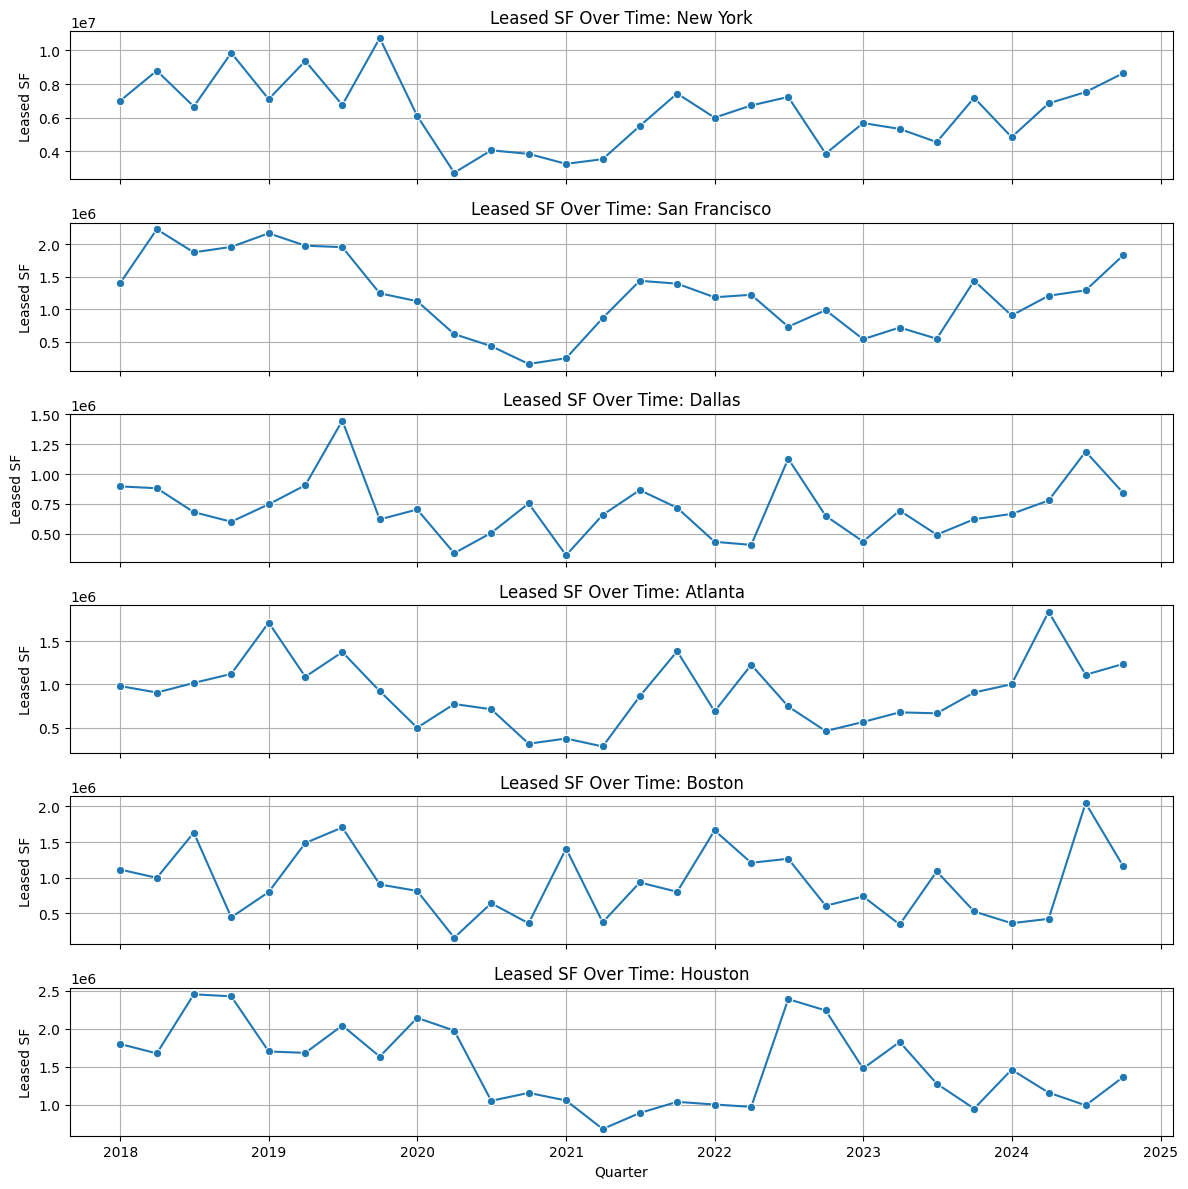

In [26]:
# Define cities to plot
selected_cities = ['New York', 'San Francisco', 'Dallas', 'Atlanta', 'Boston','Houston']

# Filter and create time column
city_df = df[df['city'].isin(selected_cities)].copy()
city_df['quarter'] = city_df['quarter'].astype(int)
city_df['year'] = city_df['year'].astype(int)
city_df['time'] = pd.PeriodIndex.from_fields(
    year=city_df['year'],
    quarter=city_df['quarter'],
    freq='Q'
).to_timestamp()

# Group by city and time
city_time = city_df.groupby(['time', 'city'])['leasedSF'].sum().reset_index()

# Create subplots
fig, axes = plt.subplots(nrows=len(selected_cities), figsize=(12, 12), sharex=True)

# Plot each city separately
for i, city in enumerate(selected_cities):
    ax = axes[i]
    data = city_time[city_time['city'] == city]
    sns.lineplot(data=data, x='time', y='leasedSF', marker='o', ax=ax)
    ax.set_title(f"Leased SF Over Time: {city}")
    ax.set_ylabel("Leased SF")
    ax.grid(True)

plt.xlabel("Quarter")
plt.tight_layout()
plt.show()


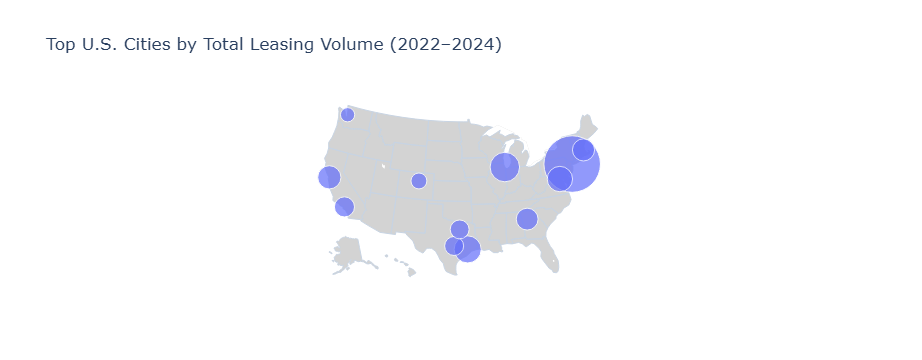

In [27]:
import pandas as pd
import plotly.express as px

# Step 1: Assign COVID period
def assign_period(year):
    if year in [2022, 2023, 2024]:
        return 'Post-COVID'
    else:
        return 'Other'

df['period'] = df['year'].apply(assign_period)

# Step 2: Group by city and sum leasing only for Post-COVID
post_covid = df[df['period'] == 'Post-COVID']
city_totals = post_covid.groupby('city')['leasedSF'].sum().reset_index()

# Step 3: Filter top 15 cities and add lat/lon (manual lookup or geocoding)
top_cities = city_totals.sort_values('leasedSF', ascending=False).head(15)

# Manually added latitude and longitude (accurate for presentation)
coordinates = {
    'New York': (40.7128, -74.0060),
    'Chicago': (41.8781, -87.6298),
    'Houston': (29.7604, -95.3698),
    'Washington': (38.9072, -77.0369),
    'San Francisco': (37.7749, -122.4194),
    'Boston': (42.3601, -71.0589),
    'Atlanta': (33.7490, -84.3880),
    'Dallas': (32.7767, -96.7970),
    'Austin': (30.2672, -97.7431),
    'Los Angeles': (34.0522, -118.2437),
    'Seattle': (47.6062, -122.3321),
    'Miami': (25.7617, -80.1918),
    'Denver': (39.7392, -104.9903),
    'Philadelphia': (39.9526, -75.1652),
    'Phoenix': (33.4484, -112.0740)
}

# Add lat/lon columns
top_cities['lat'] = top_cities['city'].map(lambda x: coordinates.get(x, (None, None))[0])
top_cities['lon'] = top_cities['city'].map(lambda x: coordinates.get(x, (None, None))[1])

# Step 4: Plot using plotly
fig = px.scatter_geo(
    top_cities,
    lat='lat',
    lon='lon',
    scope='usa',
    size='leasedSF',
    hover_name='city',
    size_max=40,
    title='Top U.S. Cities by Total Leasing Volume (2022–2024)',
    projection='albers usa',
    template='plotly_white'
)

fig.update_layout(geo=dict(showland=True, landcolor="LightGray"))
fig.show()


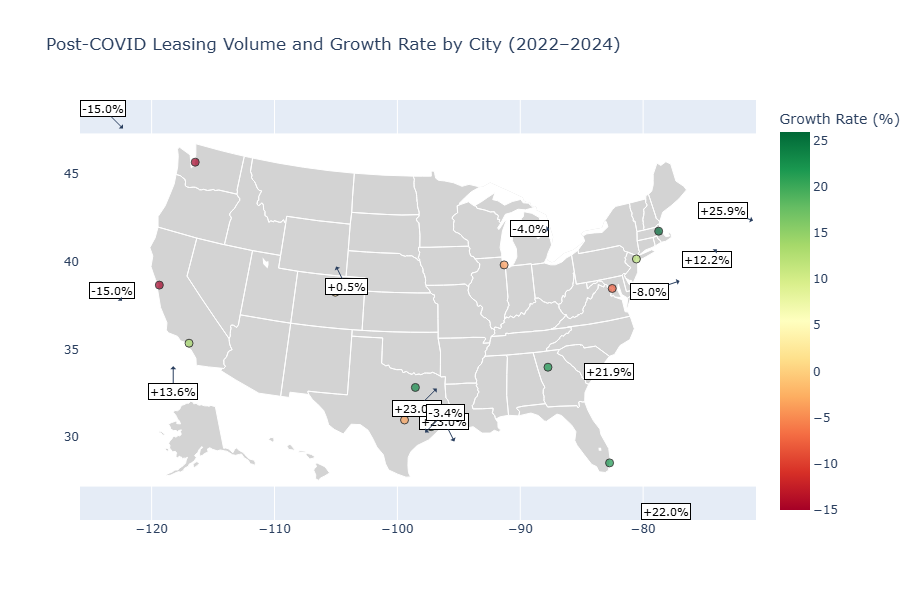

In [30]:
import pandas as pd
import plotly.graph_objects as go

# Example data
data = {
    'city': ['New York', 'Chicago', 'Houston', 'Washington', 'San Francisco', 'Boston', 'Atlanta', 'Dallas', 'Austin', 'Los Angeles', 'Miami', 'Denver', 'Seattle'],
    'lat': [40.7128, 41.8781, 29.7604, 38.9072, 37.7749, 42.3601, 33.7490, 32.7767, 30.2672, 34.0522, 25.7617, 39.7392, 47.6062],
    'lon': [-74.0060, -87.6298, -95.3698, -77.0369, -122.4194, -71.0589, -84.3880, -96.7970, -97.7431, -118.2437, -80.1918, -104.9903, -122.3321],
    'Post-COVID': [74373900, 20273810, 17133553, 15000123, 12596138, 11425577, 11124652, 8343641, 8424928, 9431243, 5100000, 4900000, 4700000],
    'growth_rate': [12.2, -4.0, 23.0, -8.0, -15.0, 25.9, 21.9, 23.0, -3.4, 13.6, 22.0, 0.5, -15.0]
}

df = pd.DataFrame(data)
df['label'] = df['growth_rate'].apply(lambda x: f"{x:+.1f}%")

# Custom annotation offset (x, y in px)
offsets = [
    (-10, 10),  # New York
    (-20, 0),   # Chicago
    (-10, -20), # Houston
    (-30, 10),  # Washington
    (-10, -10), # San Francisco
    (-30, -10), # Boston
    (20, 0),    # Atlanta
    (-20, 20),  # Dallas
    (20, -20),  # Austin
    (0, 25),    # Los Angeles
    (25, 0),    # Miami
    (10, 20),   # Denver
    (-20, -20), # Seattle
]

# Start figure
fig = go.Figure()

# Bubble layer
fig.add_trace(go.Scattergeo(
    lon=df['lon'],
    lat=df['lat'],
    text=df['city'],
    marker=dict(
        size=df['Post-COVID'] / 1e6,
        color=df['growth_rate'],
        colorscale='RdYlGn',
        colorbar_title="Growth Rate (%)",
        line_color='black',
        sizemode='area',
        sizeref=2.*max(df['Post-COVID'])/(100.**2),
        sizemin=4
    ),
    mode='markers',
    hoverinfo='text'
))

# Annotation layer
for i, row in df.iterrows():
    fig.add_annotation(
        x=row['lon'],
        y=row['lat'],
        xref='x',
        yref='y',
        text=row['label'],
        showarrow=True,
        arrowhead=1,
        ax=offsets[i][0],
        ay=offsets[i][1],
        font=dict(size=11, color='black'),
        bgcolor='white',
        bordercolor='black'
    )

# Map settings
fig.update_layout(
    title='Post-COVID Leasing Volume and Growth Rate by City (2022–2024)',
    geo=dict(
        scope='usa',
        showland=True,
        landcolor='LightGray',
        projection=dict(type='albers usa')
    ),
    height=600
)

fig.show()


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier

# 1. Load data
df = pd.read_csv('Filtered_Leases.csv')

# 2. Drop rows with missing target
df = df.dropna(subset=['transaction_type'])

# 3. Simplify transaction_type
def simplify_type(x):
    x = str(x).strip().lower()
    if 'renew' in x:
        return 'Renewal'
    elif 'new' in x:
        return 'New'
    else:
        return 'Other'
df['transaction_type'] = df['transaction_type'].apply(simplify_type)

# 4. Drop irrelevant columns
drop_cols = [
    'building_name', 'building_id', 'address', 'region', 'city', 'state',
    'internal_submarket', 'internal_class', 'company_name',
    'internal_market_cluster', 'CBD_suburban'
]
df.drop(columns=[col for col in drop_cols if col in df.columns], inplace=True)

# 5. Encode categorical variables (features)
categorical_cols = df.select_dtypes(include='object').columns.drop('transaction_type')
for col in categorical_cols:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# 6. Encode the target labels
target_encoder = LabelEncoder()
df['transaction_type_encoded'] = target_encoder.fit_transform(df['transaction_type'])

# 7. Features and labels
X = df.drop(columns=['transaction_type', 'transaction_type_encoded'])
y = df['transaction_type_encoded']

# 8. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# 9. Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 10. XGBoost model
xgb_model = XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=42,
    n_estimators=150,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8
)
xgb_model.fit(X_train_scaled, y_train)

# 11. Evaluation
y_pred = xgb_model.predict(X_test_scaled)
print("✅ Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\n✅ Classification Report:\n", classification_report(y_test, y_pred, target_names=target_encoder.classes_))


C:\Users\Kinshuk Mangal\anaconda3\envs\geo_env1\lib\site-packages\xgboost\core.py:158: UserWarning: [22:32:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


✅ Confusion Matrix:
 [[3580  172  163]
 [ 277  679  158]
 [ 330  196  342]]

✅ Classification Report:
               precision    recall  f1-score   support

         New       0.86      0.91      0.88      3915
       Other       0.65      0.61      0.63      1114
     Renewal       0.52      0.39      0.45       868

    accuracy                           0.78      5897
   macro avg       0.67      0.64      0.65      5897
weighted avg       0.77      0.78      0.77      5897



<Figure size 1200x600 with 0 Axes>

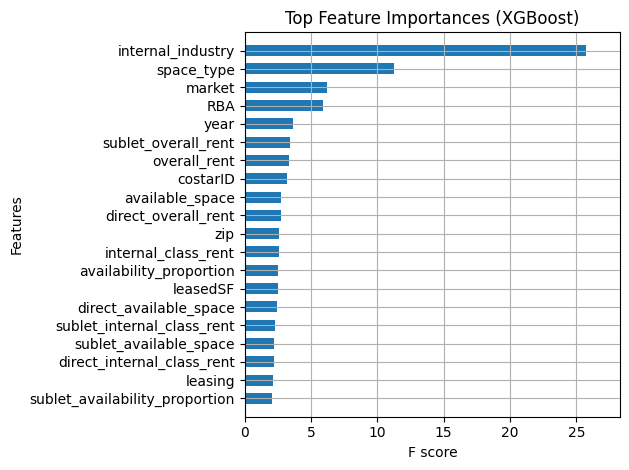

In [6]:
# 1. Create a mapping dictionary
feature_mapping = {f"f{i}": col for i, col in enumerate(X.columns)}

# 2. Plot again with true feature names
import matplotlib.pyplot as plt
from xgboost import plot_importance

plt.figure(figsize=(12, 6))
ax = plot_importance(
    xgb_model,
    importance_type='gain',
    max_num_features=20,
    height=0.6,
    show_values=False  # hide default numbers for clarity
)

# 3. Replace f0, f1... with actual feature names
yticklabels = [feature_mapping.get(label.get_text(), label.get_text()) for label in ax.get_yticklabels()]
ax.set_yticklabels(yticklabels)

plt.title("Top Feature Importances (XGBoost)")
plt.tight_layout()
plt.show()


✅ XGBoost Regressor:
RMSE: 0.31
MAE: 0.16
R² Score: 0.9998

🧪 Linear Regression R² Score: 0.8220


C:\Users\Kinshuk Mangal\AppData\Local\Temp\ipykernel_14960\2442974966.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance[:10], y=importance.index[:10], palette="viridis")


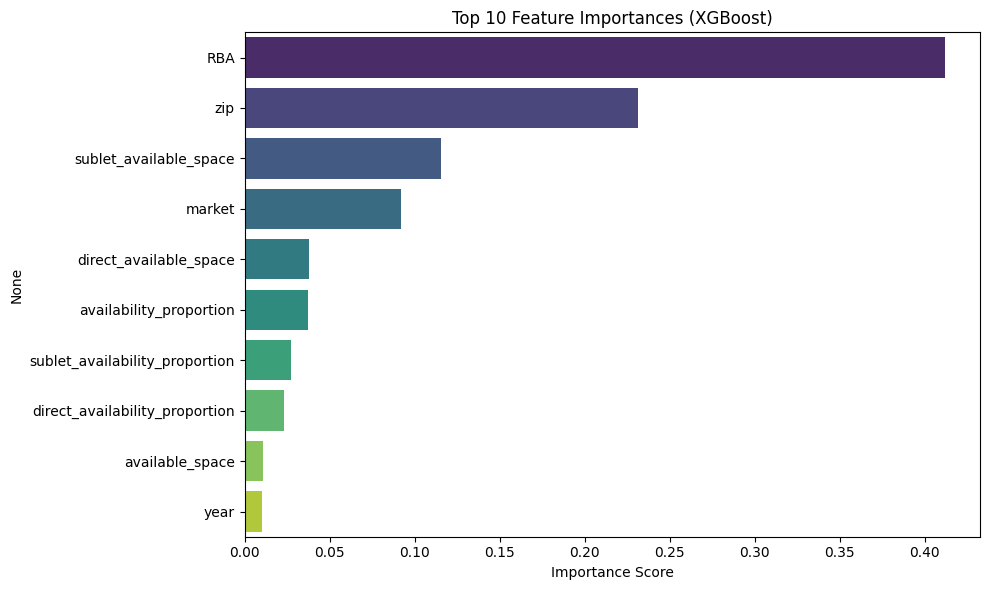

In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load the dataset
df = pd.read_csv("Filtered_Leases.csv")

# 2. Drop rows where target is missing
df = df.dropna(subset=["overall_rent"])

# 3. Drop rent-related leakage features
rent_related_cols = [
    'internal_class_rent',
    'direct_internal_class_rent',
    'direct_overall_rent',
    'sublet_internal_class_rent',
    'sublet_overall_rent',
    'leasing'
]

drop_cols = [
    "building_name", "building_id", "address", "region", "city", "state",
    "internal_submarket", "internal_class", "company_name",
    "internal_market_cluster", "CBD_suburban", "transaction_type"
]

df.drop(columns=[col for col in rent_related_cols + drop_cols if col in df.columns], inplace=True)

# 4. Encode any categorical variables
categorical_cols = df.select_dtypes(include="object").columns
for col in categorical_cols:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))

# 5. Remove highly correlated features (perfect predictors of overall_rent)
corr_matrix = df.corr(numeric_only=True)
high_corr = corr_matrix["overall_rent"].abs()
leak_cols = high_corr[high_corr > 0.99].index.tolist()
leak_cols = [col for col in leak_cols if col != "overall_rent"]
if leak_cols:
    print("⚠️ Dropping correlated leakage features:", leak_cols)
    df.drop(columns=leak_cols, inplace=True)

# 6. Drop any remaining rows with NaNs (safe for all models)
df = df.dropna()

# 7. Define features and target
X = df.drop(columns=["overall_rent"])
y = df["overall_rent"]

# 8. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 9. Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 10. Train XGBoost Regressor
xgb_model = XGBRegressor(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)
xgb_model.fit(X_train_scaled, y_train)
y_pred_xgb = xgb_model.predict(X_test_scaled)

# 11. Evaluate XGBoost
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("✅ XGBoost Regressor:")
print(f"RMSE: {rmse_xgb:.2f}")
print(f"MAE: {mae_xgb:.2f}")
print(f"R² Score: {r2_xgb:.4f}")

# 12. Sanity check: Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_lr = lr.predict(X_test_scaled)
r2_lr = r2_score(y_test, y_pred_lr)
print(f"\n🧪 Linear Regression R² Score: {r2_lr:.4f}")

# 13. Feature importance (XGBoost)
importance = pd.Series(xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=importance[:10], y=importance.index[:10], palette="viridis")
plt.title("Top 10 Feature Importances (XGBoost)")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


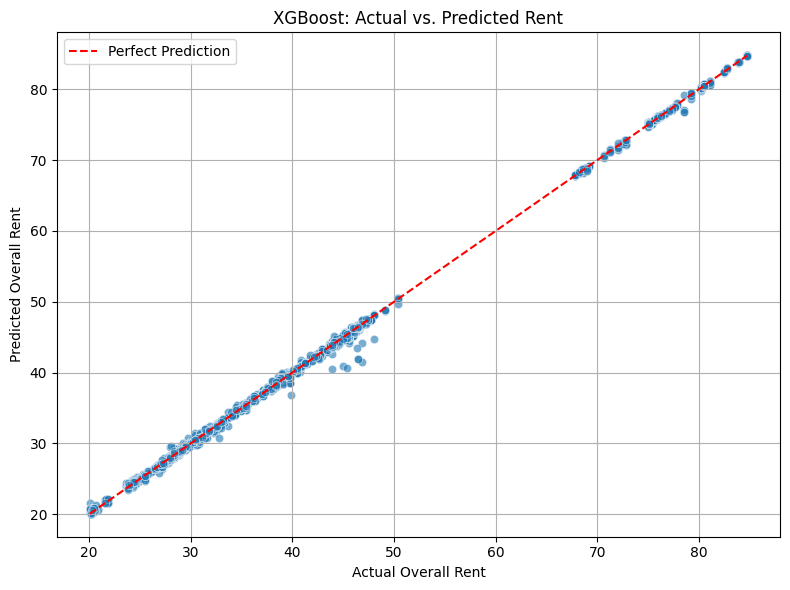

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_xgb, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', label='Perfect Prediction')
plt.xlabel("Actual Overall Rent")
plt.ylabel("Predicted Overall Rent")
plt.title("XGBoost: Actual vs. Predicted Rent")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


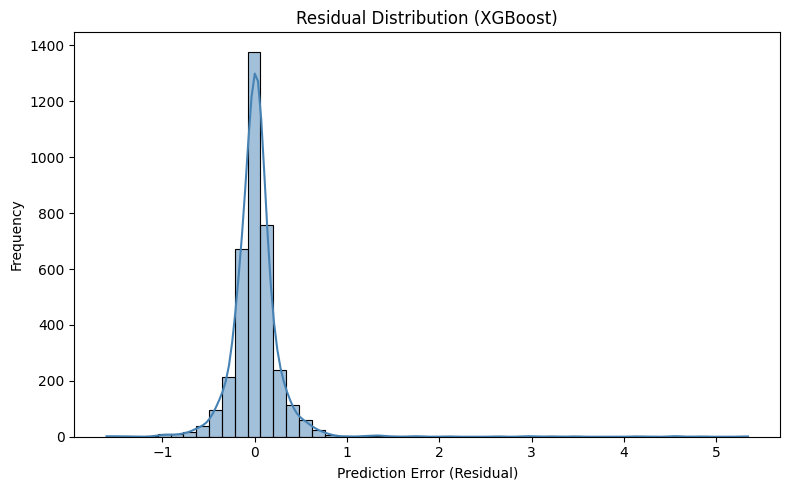

In [13]:
residuals = y_test - y_pred_xgb

plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=50, kde=True, color="steelblue")
plt.title("Residual Distribution (XGBoost)")
plt.xlabel("Prediction Error (Residual)")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


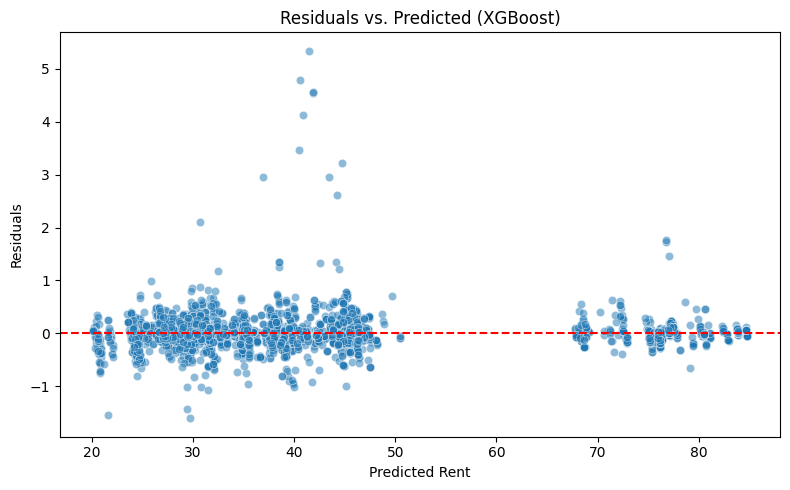

In [14]:
plt.figure(figsize=(8, 5))
sns.scatterplot(x=y_pred_xgb, y=residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Rent")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predicted (XGBoost)")
plt.tight_layout()
plt.show()


In [15]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

cv_r2_scores = cross_val_score(xgb_model, StandardScaler().fit_transform(X), y, cv=5, scoring='r2')
print("Cross-validated R² scores:", cv_r2_scores)
print("Mean R²:", round(cv_r2_scores.mean(), 4))
print("Std Dev:", round(cv_r2_scores.std(), 4))


Cross-validated R² scores: [0.9937576  0.99547205 0.99207262 0.9844108  0.9640026 ]
Mean R²: 0.9859
Std Dev: 0.0116
